# Image Generation with Autoencoders, Variational Autoencoders, or GANs

# Zeen Wang 001082883

Find an image dataset other than MNIST or CIFAR. The image dataset must be pre-approved by the TA. It also cannot be the same image dataset as another student in the class unless it is TMINST.
TMNIST. For TMNIST-Alphabet (94 characters and over 281,000 images)

Generative Architecture (60 Points)
Use a generative architecture (Autoencoders, GANs, VAEs, Diffusion Models)
Create at least 40 fake images using ONE of the generative architectures. How well did it do?  Adjust the size of the latent space. Change the network architecture. What combination of network architecture and latent space size gives the best trade-off between compression and quality?

In [1]:
import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import *
from keras import backend as K

In [2]:
# tmnist data
df_train = pd.read_csv('94_character_TMNIST.csv')
X = df_train.iloc[:, 2:786]
print(X.shape)

(274093, 784)


In [3]:
train_pct_index = int(0.8 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
X_train = X_train.values.astype('float32')/255.
X_test = X_test.values.astype('float32')/255.
output_X_train = X_train.reshape(-1,28,28,1)
output_X_test = X_test.reshape(-1,28,28,1)

print(X_train.shape, X_test.shape)

(219274, 784) (54819, 784)


In [4]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(32, activation = 'relu')(flat)

In [5]:
#AE decoder
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)

m = 128
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, batch_size=m, shuffle=True)

Epoch 1/10
1714/1714 [==============================] - 61s 36ms/step - loss: 0.1813
Epoch 2/10
1714/1714 [==============================] - 60s 35ms/step - loss: 0.1452
Epoch 3/10
1714/1714 [==============================] - 58s 34ms/step - loss: 0.1500
Epoch 4/10
1714/1714 [==============================] - 58s 34ms/step - loss: 0.1284
Epoch 5/10
1714/1714 [==============================] - 57s 34ms/step - loss: 0.1312
Epoch 6/10
1714/1714 [==============================] - 57s 33ms/step - loss: 0.1274
Epoch 7/10
1714/1714 [==============================] - 57s 34ms/step - loss: 0.1222
Epoch 8/10
1714/1714 [==============================] - 57s 33ms/step - loss: 0.1196
Epoch 9/10
1714/1714 [==============================] - 58s 34ms/step - loss: 0.1210
Epoch 10/10
1714/1714 [==============================] - 58s 34ms/step - loss: 0.1215


In [6]:
test_imgs = autoencoder.predict(output_X_test)
print(test_imgs.shape)

(54819, 28, 28, 1)


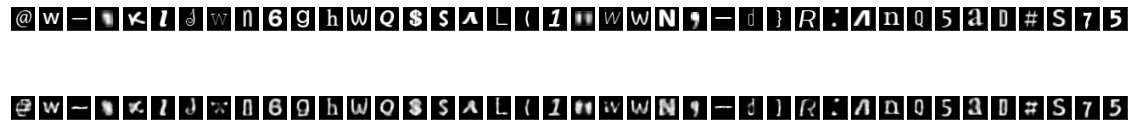

In [7]:
import matplotlib.pyplot as plt

n = 40
plt.figure(figsize=(20, 3))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(output_X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

After 10 epochs training, can simply get the performance of AE. Though there is some missing details, the shape of the image can be recognized.

As we know, the Autoencoder is made of two components, and it contains a quick reminder. The encoder gives the data from high dimensionals to a smallset neurons layer. The decoder takes the input generated by the encoder and convert them back into original shape. 

The latent space contains a compressed representation of the image, which is the only information the decoder is allowed to use to try to reconstruct the input as faithfullyas possible. To perform well, the network has to learn to extract the most relevant features in the bottleneck.


In [8]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(64, activation = 'relu')(flat)

In [9]:
#AE decoder
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)

m = 128
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, batch_size=m, shuffle=True)

Epoch 1/10
1714/1714 [==============================] - 85s 49ms/step - loss: 0.1685
Epoch 2/10
1714/1714 [==============================] - 90s 52ms/step - loss: 0.1386
Epoch 3/10
1714/1714 [==============================] - 84s 49ms/step - loss: 0.1259
Epoch 4/10
1714/1714 [==============================] - 93s 54ms/step - loss: 0.1201
Epoch 5/10
1714/1714 [==============================] - 85s 49ms/step - loss: 0.1250
Epoch 6/10
1714/1714 [==============================] - 94s 55ms/step - loss: 0.1246
Epoch 7/10
1714/1714 [==============================] - 96s 56ms/step - loss: 0.1253
Epoch 8/10
1714/1714 [==============================] - 89s 52ms/step - loss: 0.1228
Epoch 9/10
1714/1714 [==============================] - 86s 50ms/step - loss: 0.1162
Epoch 10/10
1714/1714 [==============================] - 86s 50ms/step - loss: 0.1132


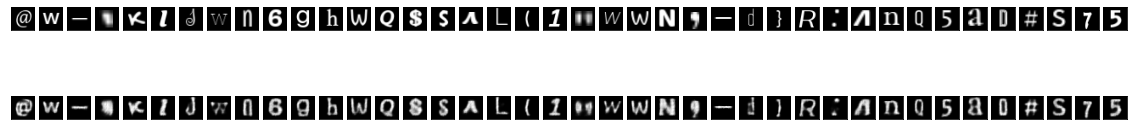

In [10]:
test_imgs = autoencoder.predict(output_X_test)

n = 40
plt.figure(figsize=(20, 3))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(output_X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(64, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(64, activation = 'relu')(flat)

In [12]:
#AE decoder
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)

m = 128
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, batch_size=m, shuffle=True)

Epoch 1/10
1714/1714 [==============================] - 83s 48ms/step - loss: 0.1807
Epoch 2/10
1714/1714 [==============================] - 80s 47ms/step - loss: 0.1495
Epoch 3/10
1714/1714 [==============================] - 81s 47ms/step - loss: 0.1329
Epoch 4/10
1714/1714 [==============================] - 91s 53ms/step - loss: 0.1310
Epoch 5/10
1714/1714 [==============================] - 89s 52ms/step - loss: 0.1227
Epoch 6/10
1714/1714 [==============================] - 92s 53ms/step - loss: 0.1211
Epoch 7/10
1714/1714 [==============================] - 85s 50ms/step - loss: 0.1120
Epoch 8/10
1714/1714 [==============================] - 88s 51ms/step - loss: 0.1135
Epoch 9/10
1714/1714 [==============================] - 88s 51ms/step - loss: 0.1186
Epoch 10/10
1714/1714 [==============================] - 86s 50ms/step - loss: 0.1126


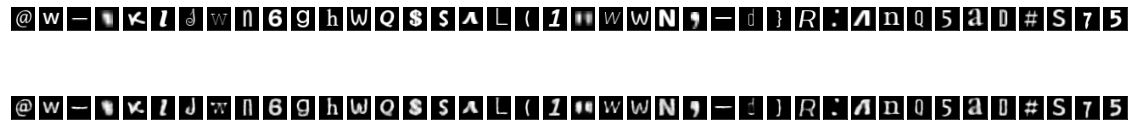

In [13]:
test_imgs = autoencoder.predict(output_X_test)

n = 40
plt.figure(figsize=(20, 3))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(output_X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

And then I change the pooling and sampling and get a better output, as we can see. The new set have more details than before. And it takes a longer time than before.

Copyright 2022 Zeen Wang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.